<a href="https://colab.research.google.com/github/ClaudioAresu/SkimLit_Project/blob/main/SkimLit_nlp_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

the paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading thrugh the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

For ground truth for this notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb



In [ ]:
# Confirme access to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fa90041e-59b0-5df3-e031-f42617950413)


## Load the data

Download the dataset from: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.48 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check the files from PubMed_20K dataset
!ls !ls pubmed-rct/PubMed_20k_RCT
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

ls: cannot access '!ls': No such file or directory
pubmed-rct/PubMed_20k_RCT:
dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20K dataset with numbers
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

 ## Preprocess data

 Now we've got some text data. it's time to become one with it.

 And one of the best waus to become one with the data is to...

 > visualize, visualize, visualize

 So with that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create function tor ead the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

# Let's think about how we want our data to look...

How I think our data would be best represented...
 


```
[{'line_number' : 0,
  'target' : 'BACKGROUND',
  'text' : "Emotional eating is associated with overaeting and the development of obesity .\n"
  'total_lines: 11},
  ...]
```


In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.
  
  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is in.
    
  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # empty abstract
  abstract_samples = []  #empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if it is and ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a  single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data) # add lien data to abstract samples list
      
    else: # ig the above condition aren't fulfilled, the line contains a labelled sentence
        abstract_lines += line
      
    
  return abstract_samples

In [ ]:
# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 547 ms, sys: 100 ms, total: 647 ms
Wall time: 688 ms


In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

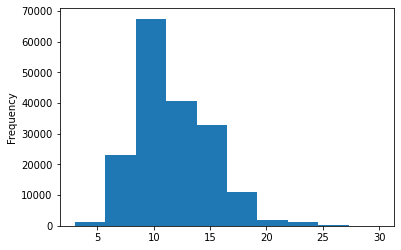

In [ ]:
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML models require numeric labels)

In [ ]:
# One Hot Encode
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label Encode

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0: Getting a baseline

our baseline will be a TF-IDF Multinomial Naive Bayes classifier.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results

--2023-03-19 12:07:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-19 12:07:57 (83.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Tokenize and Vectorize

In [ ]:
import numpy as np
from tensorflow.keras import layers


In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens 

26.338269273494777

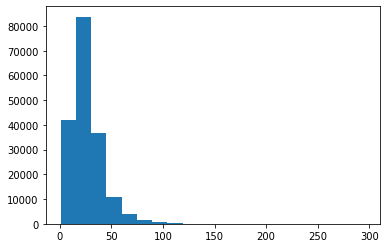

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

In [ ]:
max_tokens = 68000

In [ ]:
# create a text vectorization layer
text_vectorizer = layers.experimental.preprocessing.TextVectorization(max_tokens=max_tokens,
                                                                      output_sequence_length=output_seq_len
                                                                    )

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
more patients needed additional intervention in the mechanical method group .

Length of text: 11

Vectorized text: [[ 69  12 440 365  38   5   2 964 363  13   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab{rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab{rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

In [ ]:
# Create a token embedding layer
token_embed = layers.Embedding(len(rct_20k_text_vocab),
                             128,
                             mask_zero=True,
                             name="token_embed")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
more patients needed additional intervention in the mechanical method group .

Sentence after vectorization (before embedding):
 [[ 69  12 440 365  38   5   2 964 363  13   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
 [[[-0.02743179  0.0310995  -0.04156332 ... -0.00122593  0.01591405
   -0.00837423]
  [-0.00387361 -0.00681312  0.01513639 ... -0.04636756 -0.01075071
    0.03928411]
  [-0.00870134  0.02855542  0.02638781 ... -0.02510823 -0.01423478
    0.03047997]
  ...
  [ 0.03758771 -0.04020448 -0.01444262 ...  0.0263768   0.0430951
    0.04640087]
  [ 0.03758771 -0.04020448 -0.01444262 ...  0.0263768   0.0430951
    0.04640087]
  [ 0.03758771 -0.04020448 -0.01444262 ...  0.0263768   0.0430951
    0.04640087]]]

Embedded sentence shape: (1, 55, 128)


## Creating datasets (making sure our data loads as fast as possible)
we're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are from this two sources:
* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/guide/data_performance

In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Custom token embedding

In [ ]:
# Create the model and compile it

from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras import Model

inputs = Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model_1 = Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.15*len(valid_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 38s 48ms/step - loss: 0.9169 - accuracy: 0.6349 - val_loss: 0.6809 - val_accuracy: 0.7407
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6553 - accuracy: 0.7591 - val_loss: 0.6210 - val_accuracy: 0.7719
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.6142 - accuracy: 0.7766 - val_loss: 0.5800 - val_accuracy: 0.7906
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5865 - accuracy: 0.7911 - val_loss: 0.5615 - val_accuracy: 0.7974
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5891 - accuracy: 0.7925 - val_loss: 0.5448 - val_accuracy: 0.8027


In [ ]:
model_1_preds = model_1.evaluate(valid_dataset)
print(model_1_preds)
model_1_pred_probs = model_1.predict(valid_dataset)
print(model_1_pred_probs)

945/945 [==============================] - 3s 3ms/step - loss: 0.5611 - accuracy: 0.8010
[0.5611369609832764, 0.8010393381118774]
945/945 [==============================] - 2s 2ms/step
[[5.6374800e-01 1.4694853e-01 6.2067762e-02 1.7324759e-01 5.3988118e-02]
 [4.6414676e-01 3.1420287e-01 2.9559992e-02 1.4249058e-01 4.9599793e-02]
 [1.7464449e-01 5.9436625e-03 1.3467266e-03 8.1801945e-01 4.5717075e-05]
 ...
 [3.9519025e-05 6.5885868e-04 3.5124975e-03 3.2734126e-05 9.9575633e-01]
 [1.2037760e-01 2.6010010e-01 1.8286094e-01 7.3594898e-02 3.6306646e-01]
 [1.7087606e-01 7.3902047e-01 4.7474213e-02 1.3685162e-02 2.8944109e-02]]


In [ ]:
model_1_pred_probs = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
model_1_pred_probs

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_pred_probs)
model_1_results

{'accuracy': 80.10393221236595,
 'precision': 0.801743732443804,
 'recall': 0.8010393221236595,
 'f1': 0.7978624484508351}

## Model 2: Feature extraction Model with pretrained token embedding

the paper originally used GloVe embeddings, we will uitilize the USE: https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
 # Download pretrained TensorFlow Hub USE
 import tensorflow_hub as hub
 tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         trainable=False,
                                         name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentences = random.choice(train_sentences)
print(f"Random sentences:\n {random_train_sentences}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentences])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentences:
 significant differences in clinical and functional parameters observed during the @-week blinded period were not apparent following the addition of open-label adalimumab to mtx .
Sentence after embedding:
[-0.02349114 -0.05031712 -0.03312924 -0.00683201 -0.00561405  0.01251668
  0.07265092  0.02540432 -0.04415213  0.06133562  0.08197621  0.05271005
  0.02332358  0.01066818  0.04212893  0.04178737 -0.07869607  0.05640506
  0.03197829  0.02333928 -0.03905722  0.07794665 -0.06188112  0.03551471
 -0.04234323 -0.07164401 -0.06355062  0.0590615  -0.06517551 -0.02703695]

Length of sentence embedding: 512


In [ ]:
# Define feature extraction model
inputs = Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = Model(inputs, outputs, name="model_2_USE_feature_extractor")

#Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
)

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9196 - accuracy: 0.6514 - val_loss: 0.7949 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7675 - accuracy: 0.7006 - val_loss: 0.7536 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7501 - accuracy: 0.7128 - val_loss: 0.7381 - val_accuracy: 0.7124


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7402 - accuracy: 0.7145


[0.7401890158653259, 0.7144843339920044]

In [ ]:
model_2.evaluate(test_dataset)

942/942 [==============================] - 11s 11ms/step - loss: 0.7536 - accuracy: 0.7082


[0.7535862326622009, 0.7082462310791016]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)

945/945 [==============================] - 10s 10ms/step


In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.44843108698531,
 'precision': 0.7149628468809405,
 'recall': 0.7144843108698531,
 'f1': 0.7113781754948498}

## Model 3: Conv1D with character embeddings

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentences)

's i g n i f i c a n t   d i f f e r e n c e s   i n   c l i n i c a l   a n d   f u n c t i o n a l   p a r a m e t e r s   o b s e r v e d   d u r i n g   t h e   @ - w e e k   b l i n d e d   p e r i o d   w e r e   n o t   a p p a r e n t   f o l l o w i n g   t h e   a d d i t i o n   o f   o p e n - l a b e l   a d a l i m u m a b   t o   m t x   .'

In [ ]:
# Split seqauence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

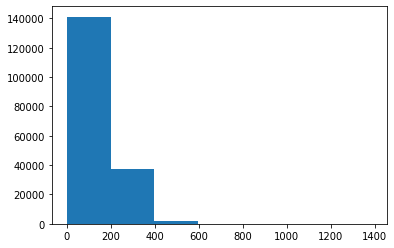

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits #+ string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

In [ ]:
from keras.layers import TextVectorization
# create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # we add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len)

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab: {len(char_vocab)}")
print(f"Most common characters in the vocab{char_vocab[:5]}")
print(f"Least common characters in the vocab{char_vocab[-5:]}")

Number of characters in vocab: 28
Most common characters in the vocab['', '[UNK]', 'e', 't', 'i']
Least common characters in the vocab['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorizer_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorizer_chars}\n")
print(f"Length of vectorized chars: {len(vectorizer_chars[0])}")

Charified text:
 t h e   p r i m a r y   o u t c o m e - r e d u c t i o n   i n   r i s k   f o r   h y p o g l y c e m i a   a s   m e a s u r e d   b y   t h e   l o w   b l o o d   g l u c o s e   (   b g   )   i n d e x   (   l g b i   )   -   r e s u l t e d   i n   a n   e f f e c t   s i z e   o f   @   ,   p   =   @   ,   w i t h   a   t w o f o l d   r e d u c t i o n   o f   h y p o g l y c e m i a   r e q u i r i n g   c a r b o h y d r a t e   t r e a t m e n t   :   @   v s .   @   e p i s o d e s / s e s s i o n   o n   c l c   v e r s u s   o l   (   p   =   @   )   .
Length of random_train_chars: 230
Vectorized chars:
[[ 3 13  2 14  8  4 15  5  8 19  7 16  3 11  7 15  2  8  2 10 16 11  3  4
   7  6  4  6  8  4  9 23 17  7  8 13 19 14  7 18 12 19 11  2 15  4  5  5
   9 15  2  5  9 16  8  2 10 22 19  3 13  2 12  7 20 22 12  7  7 10 18 12
  16 11  7  9  2 22 18  4  6 10  2 24 12 18 22  4  8  2  9 16 12  3  2 10
   4  6  5  6  2 17 17  2 11  3  9  4 25  2  7 17 14 20  4  3

In [ ]:
char_embed = layers.Embedding(len(char_vocab),
                                  25, # as in the paper
                                  mask_zero=True,
                                  name="char_embed")

In [ ]:
# Test out character embedding layer
print(f"Charified text: \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded characters:\n{char_embed_example}\n")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text: 
 t h e   p r i m a r y   o u t c o m e - r e d u c t i o n   i n   r i s k   f o r   h y p o g l y c e m i a   a s   m e a s u r e d   b y   t h e   l o w   b l o o d   g l u c o s e   (   b g   )   i n d e x   (   l g b i   )   -   r e s u l t e d   i n   a n   e f f e c t   s i z e   o f   @   ,   p   =   @   ,   w i t h   a   t w o f o l d   r e d u c t i o n   o f   h y p o g l y c e m i a   r e q u i r i n g   c a r b o h y d r a t e   t r e a t m e n t   :   @   v s .   @   e p i s o d e s / s e s s i o n   o n   c l c   v e r s u s   o l   (   p   =   @   )   .

Embedded characters:
[[[-0.01569803 -0.02953632  0.00468769 ...  0.00314865 -0.03934277
   -0.01902717]
  [ 0.01206065  0.00175861 -0.0472379  ... -0.01822935  0.00594069
   -0.01206384]
  [ 0.02155553 -0.00658999 -0.00293845 ... -0.03876003 -0.00937135
   -0.01446117]
  ...
  [-0.03348247 -0.04916322 -0.03205385 ...  0.03738334 -0.00777685
   -0.00742334]
  [-0.03348247 -0.04916322 -0.03205385 ...  0.03

In [ ]:
# Create char level datasetsl
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Create layers
inputs = Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax", name="model_3_conv1d_char_embeddings")(x)
model_3 = Model(inputs, outputs)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                                    epochs=3,
                                    steps_per_epoch=int(0.1 * len(train_char_dataset)),
                                    validation_data=(valid_char_dataset),
                                    validation_steps=int(0.1 * len(valid_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2621 - accuracy: 0.4903 - val_loss: 1.0524 - val_accuracy: 0.5781
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0103 - accuracy: 0.5961 - val_loss: 0.9398 - val_accuracy: 0.6370
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9297 - accuracy: 0.6363 - val_loss: 0.8714 - val_accuracy: 0.6596


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.19820163, 0.53914577, 0.03816687, 0.19897972, 0.025506  ],
       [0.20117357, 0.52735746, 0.00980422, 0.21264455, 0.0490202 ],
       [0.071205  , 0.22581396, 0.1629386 , 0.47505358, 0.06498899],
       ...,
       [0.01956936, 0.04014998, 0.10962509, 0.0308352 , 0.79982036],
       [0.00791196, 0.02169833, 0.34828413, 0.00657705, 0.6155285 ],
       [0.5018426 , 0.32334363, 0.0841463 , 0.07985427, 0.0108132 ]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 65.91089633258308,
 'precision': 0.6480683604698652,
 'recall': 0.6591089633258308,
 'f1': 0.6452033326769725}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid token embedding)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level embedding model (similar to `model_3`)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figyure 1 and section 4.2 of the original
5. Construct a model which takes token and character-level sequences as input and produces sequnce label probabilities outputs

In [ ]:
# Setup token inputs/model
token_inputs = Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(token_inputs, token_outputs)

# Setup char inputs/model
char_inputs = Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# Combine 1 & 2
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
# Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

# Cosntruct model with char and token inputs
model_4 = Model(inputs=[token_model.input, char_model.input],
                outputs=output_layer,
                name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

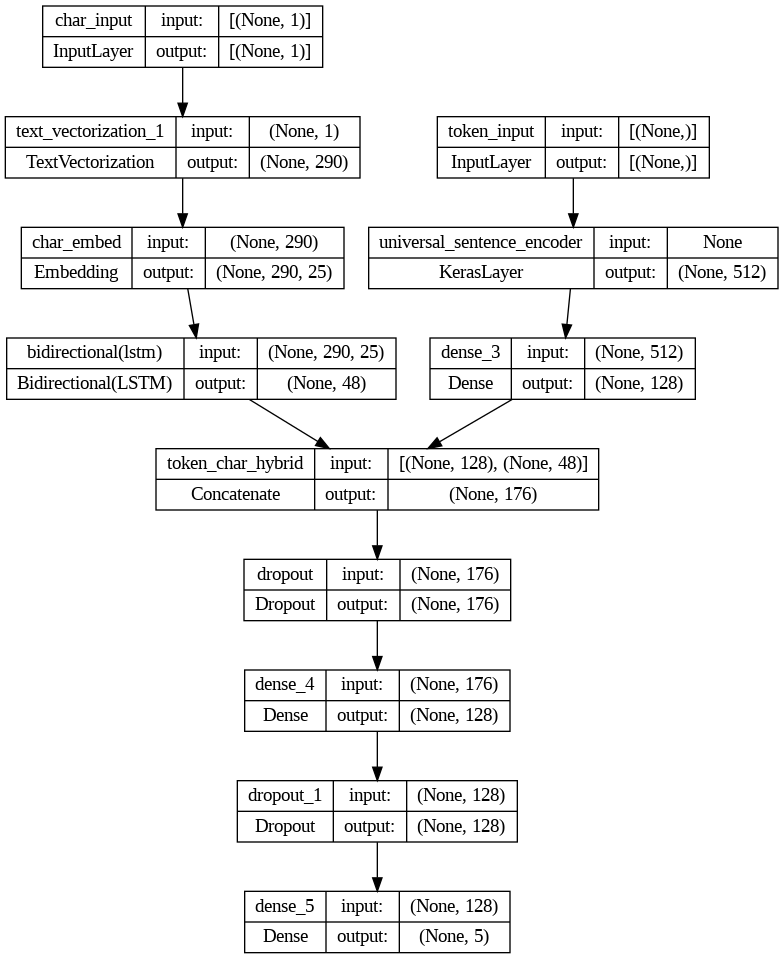

In [ ]:
# Plot hybrid token and character Model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

## Combining token and character data into a tf.data.Dataset

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting a model on token and character-level sequences

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 44s 60ms/step - loss: 0.9825 - accuracy: 0.6089 - val_loss: 0.7790 - val_accuracy: 0.7031
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.7965 - accuracy: 0.6918 - val_loss: 0.7160 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7715 - accuracy: 0.7064 - val_loss: 0.6908 - val_accuracy: 0.7367


In [ ]:
model_4_preds = model_4.predict(val_char_token_dataset)
model_4_pred_probs = model_4.evaluate(val_char_token_dataset)

model_4_preds, model_4_pred_probs

945/945 [==============================] - 20s 21ms/step - loss: 0.6930 - accuracy: 0.7357


(array([[4.2365170e-01, 3.3443910e-01, 5.4809940e-03, 2.2778343e-01,
         8.6448323e-03],
        [3.3294171e-01, 4.3615353e-01, 3.8622525e-03, 2.2435226e-01,
         2.6902934e-03],
        [2.5122631e-01, 6.9638088e-02, 5.2122194e-02, 5.9474063e-01,
         3.2272764e-02],
        ...,
        [4.7370093e-04, 1.0859374e-02, 6.2829278e-02, 1.8189792e-04,
         9.2565572e-01],
        [7.8552524e-03, 6.7684367e-02, 1.9126917e-01, 3.4539548e-03,
         7.2973728e-01],
        [3.6934540e-01, 3.3772919e-01, 2.1173786e-01, 2.9884035e-02,
         5.1303498e-02]], dtype=float32),
 [0.6929970979690552, 0.7357010245323181])

In [ ]:
model_4_pred = tf.argmax(model_4_preds, axis=1)

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_pred)


In [ ]:
model_4_results

{'accuracy': 73.57010459420098,
 'precision': 0.7352522315036033,
 'recall': 0.7357010459420098,
 'f1': 0.7333973763528392}

## Model 5: Transfer learning with feature engineering(positional arguments)

> 🔑**Note:** features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

In [ ]:
 # Check the first abstract of our training data
 train_samples[:4]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11}]

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

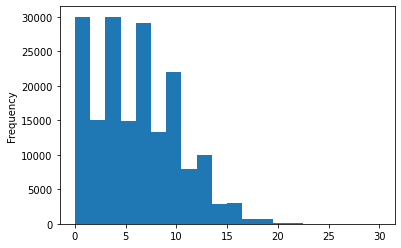

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist(bins=20)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot.shape, val_line_numbers_one_hot.shape, test_line_numbers_one_hot.shape

(TensorShape([180040, 15]), TensorShape([30212, 15]), TensorShape([30135, 15]))

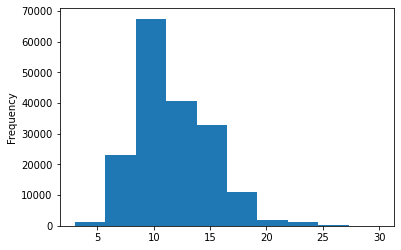

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, val_total_lines_one_hot.shape, test_total_lines_one_hot.shape

(TensorShape([180040, 20]), TensorShape([30212, 20]), TensorShape([30135, 20]))

### Building a tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3,4 & 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs and outputs of 1, 2, 3 & 4 into a `tf.keras.Model`

In [ ]:
# Token Inputs
token_inputs = Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(inputs=token_inputs,
                    outputs=token_outputs)

# Char Inputs
char_inputs = Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = Model(inputs=char_inputs,
                   outputs=char_bi_lstm)

# Create Line_numbers model
line_number_inputs = Input(shape=(15,), name="line_number_inputs")
line_number_outputs = Dense(32, activation="relu")(line_number_inputs)
line_number_model = Model(inputs=line_number_inputs,
                       outputs=line_number_outputs)

# Create Total_lines model
line_total_inputs = Input(shape=(20,), name="line_total_inputs")
line_total_outputs = Dense(32, activation="relu")(line_total_inputs)
line_total_model = Model(inputs=line_total_inputs,
                       outputs=line_total_outputs)

# Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
# Add droupout of 50%
combined_dense = Dense(256, activation="relu")(combined_embeddings)
combined_dropout = layers.Dropout(0.5)(combined_dense)

# Combine positional embedding with combined token and char embeddings
tribid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                               line_total_model.output,
                                                                               combined_dropout])
# Create output layer
output_layer = Dense(5, activation="softmax", name="output_layer")(tribid_embeddings)

# Put together model
model_5 = Model(inputs=[line_number_model.input,
                        line_total_model.input,
                        token_model.input,
                        char_model.input], outputs=output_layer, name="model_5_tribid")

In [ ]:
model_5.summary()

Model: "model_5_tribid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]

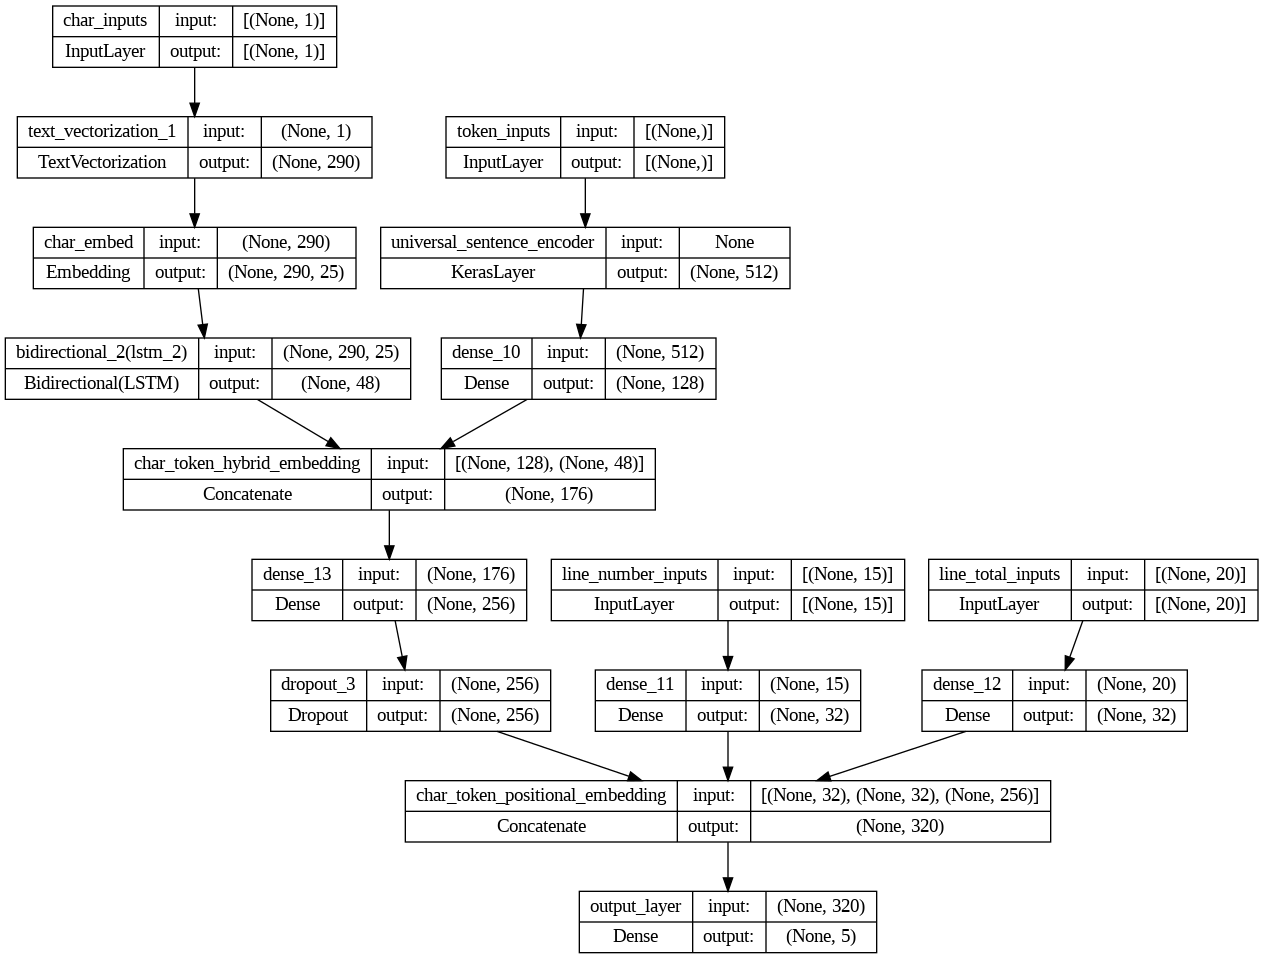

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label smoothing to help prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
#Create the remaining datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_all_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_all_dataset = train_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_all_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_all_dataset = val_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)







In [ ]:
for element in val_all_dataset:
  print(element)
  break

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_all_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_all_dataset)),
                              validation_data=val_all_dataset,
                              validation_steps=int(0.1 * len(val_all_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 53ms/step - loss: 1.0895 - accuracy: 0.7304 - val_loss: 0.9795 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9648 - accuracy: 0.8158 - val_loss: 0.9488 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9485 - accuracy: 0.8228 - val_loss: 0.9402 - val_accuracy: 0.8298


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_all_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[0.46612945, 0.1050309 , 0.01202726, 0.39693448, 0.01987799],
       [0.47861665, 0.09357893, 0.0358422 , 0.38154915, 0.01041303],
       [0.26105082, 0.12044219, 0.12636922, 0.42634192, 0.0657958 ],
       ...,
       [0.03173191, 0.1061243 , 0.03721569, 0.032609  , 0.7923191 ],
       [0.02844974, 0.286733  , 0.09760928, 0.03106012, 0.55614793],
       [0.29944482, 0.505611  , 0.11179257, 0.04125055, 0.04190104]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_5_preds)

In [ ]:
model_5_results

{'accuracy': 83.30133721699987,
 'precision': 0.8322631248355792,
 'recall': 0.8330133721699987,
 'f1': 0.8323190712076325}

## Model 6: Model 5 + custom token embeddings

In [ ]:
# Token Inputs
token_inputs = Input(shape=(1, ), dtype=tf.string)
token_vectorized = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectorized)
token_Conv1D= Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
token_GAP = GlobalAveragePooling1D()(token_Conv1D)
token_outputs = Dense(128, activation="relu")(token_GAP)
token_model = Model(inputs=token_inputs,
                    outputs=token_outputs)

# Char Inputs
char_inputs = Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = Model(inputs=char_inputs,
                   outputs=char_bi_lstm)

# Create Line_numbers model
line_number_inputs = Input(shape=(15,), name="line_number_inputs")
line_number_outputs = Dense(32, activation="relu")(line_number_inputs)
line_number_model = Model(inputs=line_number_inputs,
                       outputs=line_number_outputs)

# Create Total_lines model
line_total_inputs = Input(shape=(20,), name="line_total_inputs")
line_total_outputs = Dense(32, activation="relu")(line_total_inputs)
line_total_model = Model(inputs=line_total_inputs,
                       outputs=line_total_outputs)

# Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
# Add droupout of 50%
combined_dense = Dense(256, activation="relu")(combined_embeddings)
combined_dropout = layers.Dropout(0.5)(combined_dense)

# Combine positional embedding with combined token and char embeddings
tribid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                               line_total_model.output,
                                                                               combined_dropout])
# Create output layer
output_layer = Dense(5, activation="softmax", name="output_layer")(tribid_embeddings)

# Put together model
model_6 = Model(inputs=[line_number_model.input,
                        line_total_model.input,
                        token_model.input,
                        char_model.input], outputs=output_layer, name="model_6_tribid_custom_token")

In [ ]:
# Compile the model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label smoothing to help prevent overfitting
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "model_6_tribid_custom_token"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['input_7[0][0]']                
 ization)                                                                                         
                                                                                                  
 token_embed (Embedding)        (None, 55, 128)      8299648     ['text_vectorization[4][0]']     
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []     

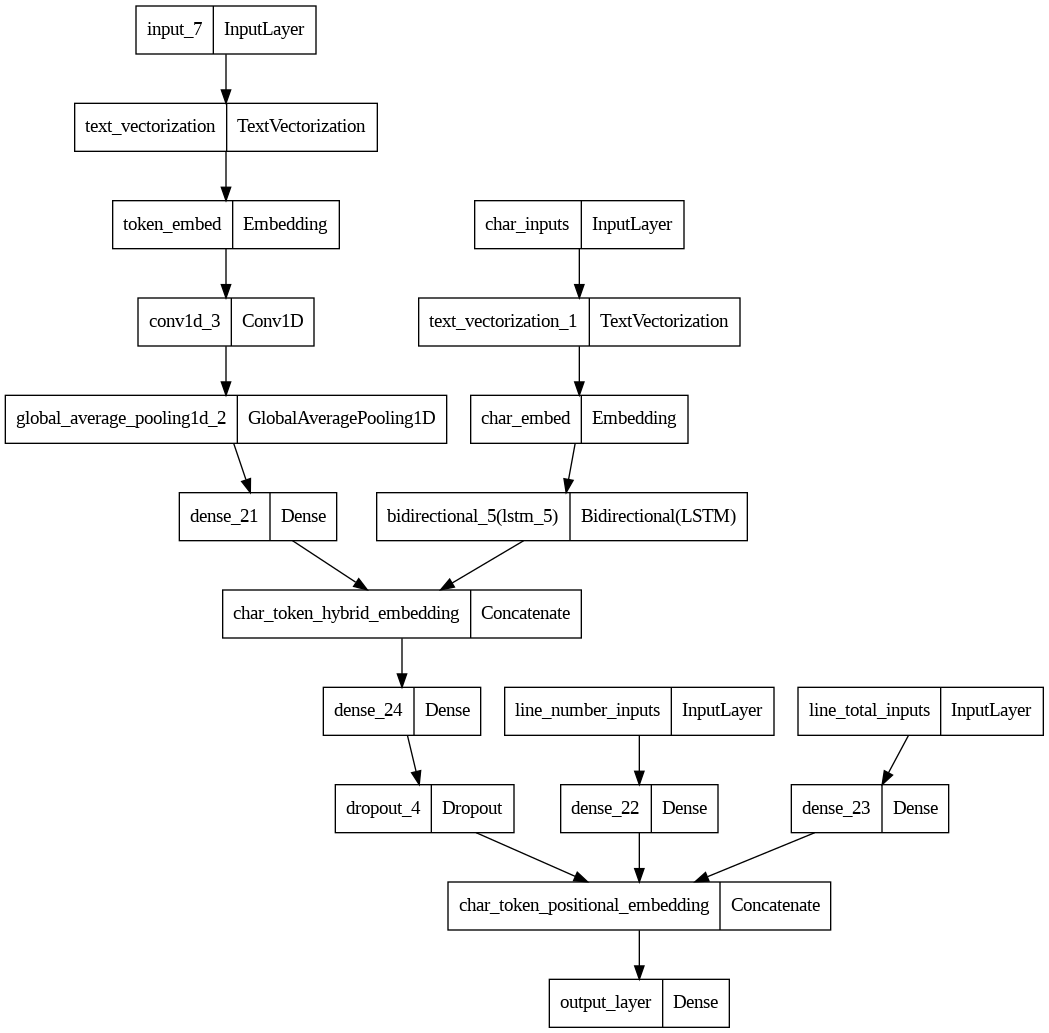

In [ ]:
plot_model(model_6)

In [ ]:
history_model_6 = model_6.fit(train_all_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_all_dataset)),
                              validation_data=val_all_dataset,
                              validation_steps=int(0.1 * len(val_all_dataset)))

Epoch 1/3
562/562 [==============================] - 52s 73ms/step - loss: 1.4693 - accuracy: 0.4014 - val_loss: 1.3072 - val_accuracy: 0.5136
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 1.1911 - accuracy: 0.6628 - val_loss: 1.0846 - val_accuracy: 0.7570
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 1.0632 - accuracy: 0.7699 - val_loss: 1.0229 - val_accuracy: 0.7909


In [ ]:
model_6_pred_probs = model_6.predict(val_all_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

945/945 [==============================] - 11s 12ms/step


{'accuracy': 79.34926519263868,
 'precision': 0.7877255344607336,
 'recall': 0.7934926519263868,
 'f1': 0.7884552439937002}

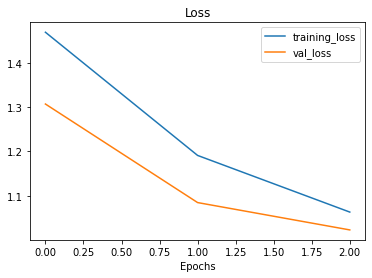

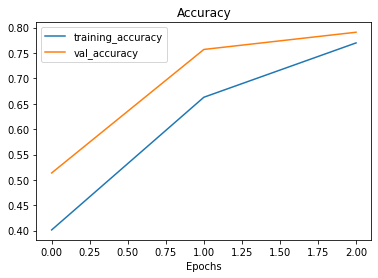

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_6)

In [ ]:
# Fit for another 3 epochs
history_model_6_extended = model_6.fit(train_all_dataset,
                                        epochs=6,
                                        initial_epoch=3,
                                        steps_per_epoch=int(0.1 * len(train_all_dataset)),
                                        validation_data=val_all_dataset,
                                        validation_steps=int(0.1 * len(val_all_dataset)))

Epoch 4/6
562/562 [==============================] - 24s 43ms/step - loss: 1.0127 - accuracy: 0.7957 - val_loss: 0.9887 - val_accuracy: 0.8105
Epoch 5/6
562/562 [==============================] - 24s 42ms/step - loss: 0.9678 - accuracy: 0.8247 - val_loss: 0.9628 - val_accuracy: 0.8182
Epoch 6/6
562/562 [==============================] - 21s 37ms/step - loss: 0.9450 - accuracy: 0.8388 - val_loss: 0.9486 - val_accuracy: 0.8268


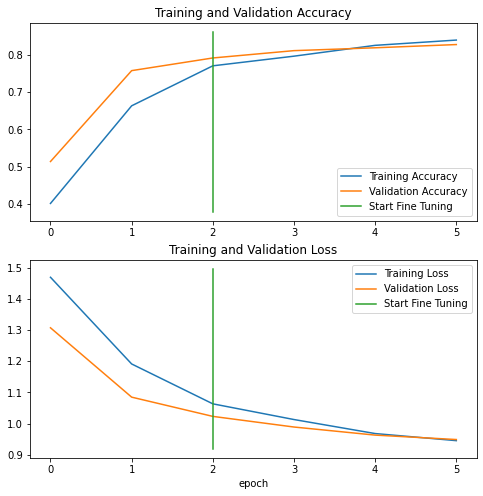

In [ ]:
from helper_functions import compare_historys
compare_historys(history_model_6,
                 history_model_6_extended,
                 initial_epochs=3)

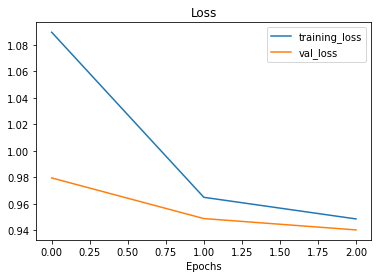

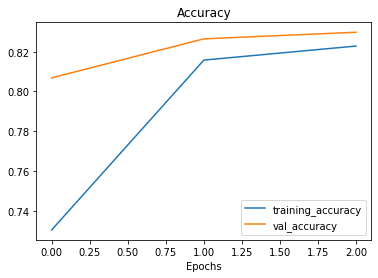

In [ ]:
plot_loss_curves(history_model_5)

## Trying SGD on models 5 and 6


In [ ]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label smoothing to help prevent overfitting
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

In [ ]:
history_model_5_SGD = model_5.fit(train_all_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_all_dataset)),
                              validation_data=val_all_dataset,
                              validation_steps=int(0.1 * len(val_all_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 54ms/step - loss: 0.9010 - accuracy: 0.8626 - val_loss: 0.9092 - val_accuracy: 0.8497
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.8801 - accuracy: 0.8785 - val_loss: 0.9078 - val_accuracy: 0.8541
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.8653 - accuracy: 0.8928 - val_loss: 0.9079 - val_accuracy: 0.8501


In [ ]:
model_5_SGD_pred_probs = model_5.predict(val_all_dataset)
model_5_SGD_preds = tf.argmax(model_5_SGD_pred_probs, axis=1)
model_5_SGD_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_SGD_preds)
model_5_SGD_results

945/945 [==============================] - 21s 19ms/step


{'accuracy': 84.78419171190255,
 'precision': 0.8466626014079437,
 'recall': 0.8478419171190256,
 'f1': 0.846148617650275}

In [ ]:
# Compile the model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label smoothing to help prevent overfitting
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

In [ ]:
history_model_6_SGD = model_6.fit(train_all_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_all_dataset)),
                              validation_data=val_all_dataset,
                              validation_steps=int(0.1 * len(val_all_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 64ms/step - loss: 0.9366 - accuracy: 0.8394 - val_loss: 0.9512 - val_accuracy: 0.8208
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9164 - accuracy: 0.8553 - val_loss: 0.9400 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9087 - accuracy: 0.8624 - val_loss: 0.9403 - val_accuracy: 0.8251


In [ ]:
model_6_SGD_pred_probs = model_6.predict(val_all_dataset)
model_6_SGD_preds = tf.argmax(model_6_SGD_pred_probs, axis=1)
model_6_SGD_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_SGD_preds)
model_6_SGD_results

945/945 [==============================] - 14s 12ms/step


{'accuracy': 82.66582814775586,
 'precision': 0.8237657822766581,
 'recall': 0.8266582814775586,
 'f1': 0.823975184828497}

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results,
                                  "model_6_tribid_custom_token": model_6_results,
                                  "model_5_pos_char_token_embedding_SGD": model_5_SGD_results,
                                  "model_6_tribid_custom_token_SGD": model_6_SGD_results})
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.801039,0.801744,0.801039,0.797862
model_2_pretrained_token_embedding,0.714484,0.714963,0.714484,0.711378
model_3_custom_char_embedding,0.659109,0.648068,0.659109,0.645203
model_4_hybrid_char_token_embedding,0.735701,0.735252,0.735701,0.733397
model_5_pos_char_token_embedding,0.833013,0.832263,0.833013,0.832319
model_6_tribid_custom_token,0.793493,0.787726,0.793493,0.788455
model_5_pos_char_token_embedding_SGD,0.847842,0.846663,0.847842,0.846149
model_6_tribid_custom_token_SGD,0.826658,0.823766,0.826658,0.823975


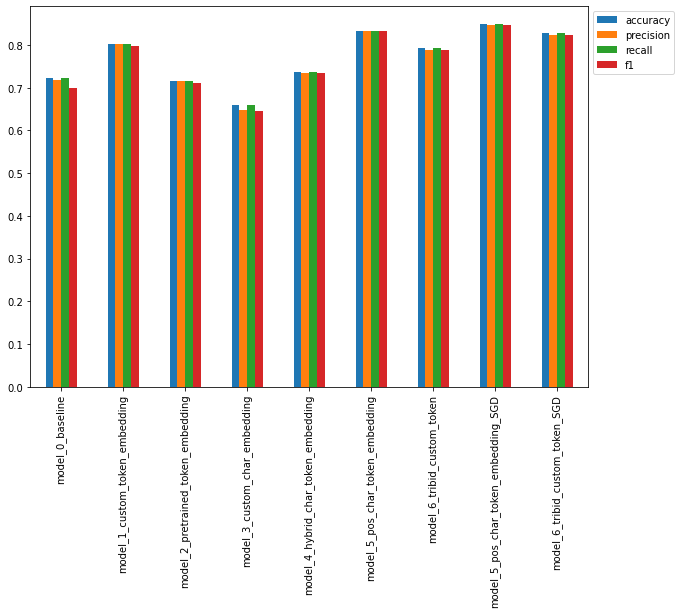

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

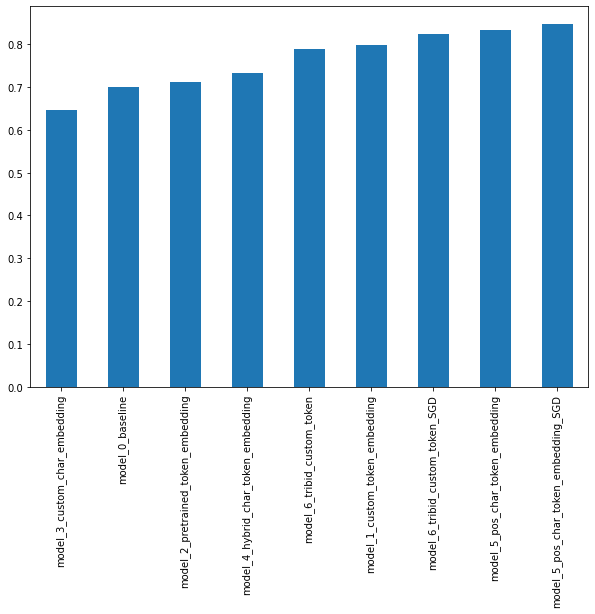

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7));

## Save and load model

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_all_dataset)
loaded_pred = tf.argmax(loaded_pred_probs, axis=1)
loaded_pred[:10]

945/945 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_pred)
loaded_model_results

{'accuracy': 84.74447239507481,
 'precision': 0.8462061283222218,
 'recall': 0.8474447239507481,
 'f1': 0.8458803832463474}

In [ ]:
assert model_5_SGD_results == loaded_model_results

AssertionError: ignored

In [ ]:
loaded_model.summary()

Model: "model_5_tribid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]

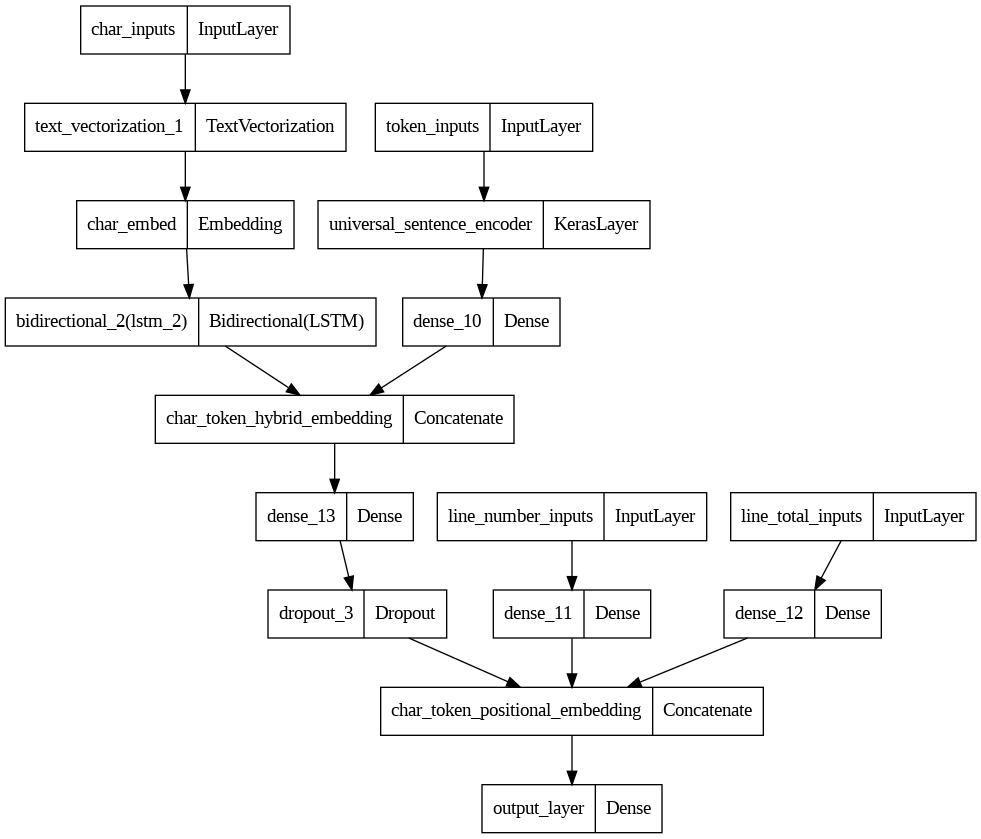

In [ ]:
plot_model(loaded_model)

In [ ]:
from google.colab import files
!zip -r /content/skimlit_tribrid_model.zip /content/skimlit_tribrid_model


zip error: Invalid command arguments (cannot write zip file to terminal)
  adding: content/skimlit_tribrid_model/ (stored 0%)
  adding: content/skimlit_tribrid_model/variables/ (stored 0%)
  adding: content/skimlit_tribrid_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/skimlit_tribrid_model/variables/variables.index (deflated 77%)
  adding: content/skimlit_tribrid_model/fingerprint.pb (stored 0%)
  adding: content/skimlit_tribrid_model/assets/ (stored 0%)
  adding: content/skimlit_tribrid_model/saved_model.pb (deflated 72%)
  adding: content/skimlit_tribrid_model/keras_metadata.pb (deflated 91%)


In [ ]:
files.download("/content/skimlit_tribrid_model.zip")

## Reload downloaded file

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [ ]:
loaded_gs_model = tf.keras.models.load_mode("skimlit_gs_model/skimlit_tribrid_model/")

In [ ]:
# Evaluate the loaded Google Storage model
loaded_gs_model.evaluate(val_all_dataset)